In [3]:
# voor data handling
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import math

# voor plots
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap # LET OP: installeren met pip install umap-learn (dus NIET: pip install umap)
sns.set_style('darkgrid')

from sklearn.mixture import GaussianMixture
import optuna
import plotly

# voor hiërarchisch clusteren
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# voor bootstrapping
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# voor testen op significante verschillen
from scipy.stats import chi2_contingency, kruskal, multivariate_normal

# voor uitvoeren DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# voor uitvoeren HDBSCAN*
# installeren met: pip install hdbscan
import hdbscan

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv(r"C:\Users\mitch\OneDrive\Documenten\Studie-Toegepaste-wiskunde\statistiek\stat5\Eindopdracht\college_math.csv", sep = ',')
useless_var = ["age", "gender"]
num_var = [
    "commute_minutes",
    "grade_final",
    "grade_period1",
    "grade_period2",
    "past_failure",
    "school_absences",
    "weekly_study_hours"
]
bin_var = [
    "extra_paid_classes",
    "internet_access",
    "support_family",
    "support_school"
]
ord_var = [
    "alcohol_weekday",
    "alcohol_weekend",
    "free_time",
    "health_status",
    "social_outings"
]


In [5]:
max(df.commute_minutes)

89

In [6]:
df.past_failures.unique()

array([0, 3, 1, 2], dtype=int64)

In [7]:
df3 = df.drop(columns=useless_var)
df2 = df3.drop(columns=bin_var)
df1 = df2.drop(columns=ord_var)

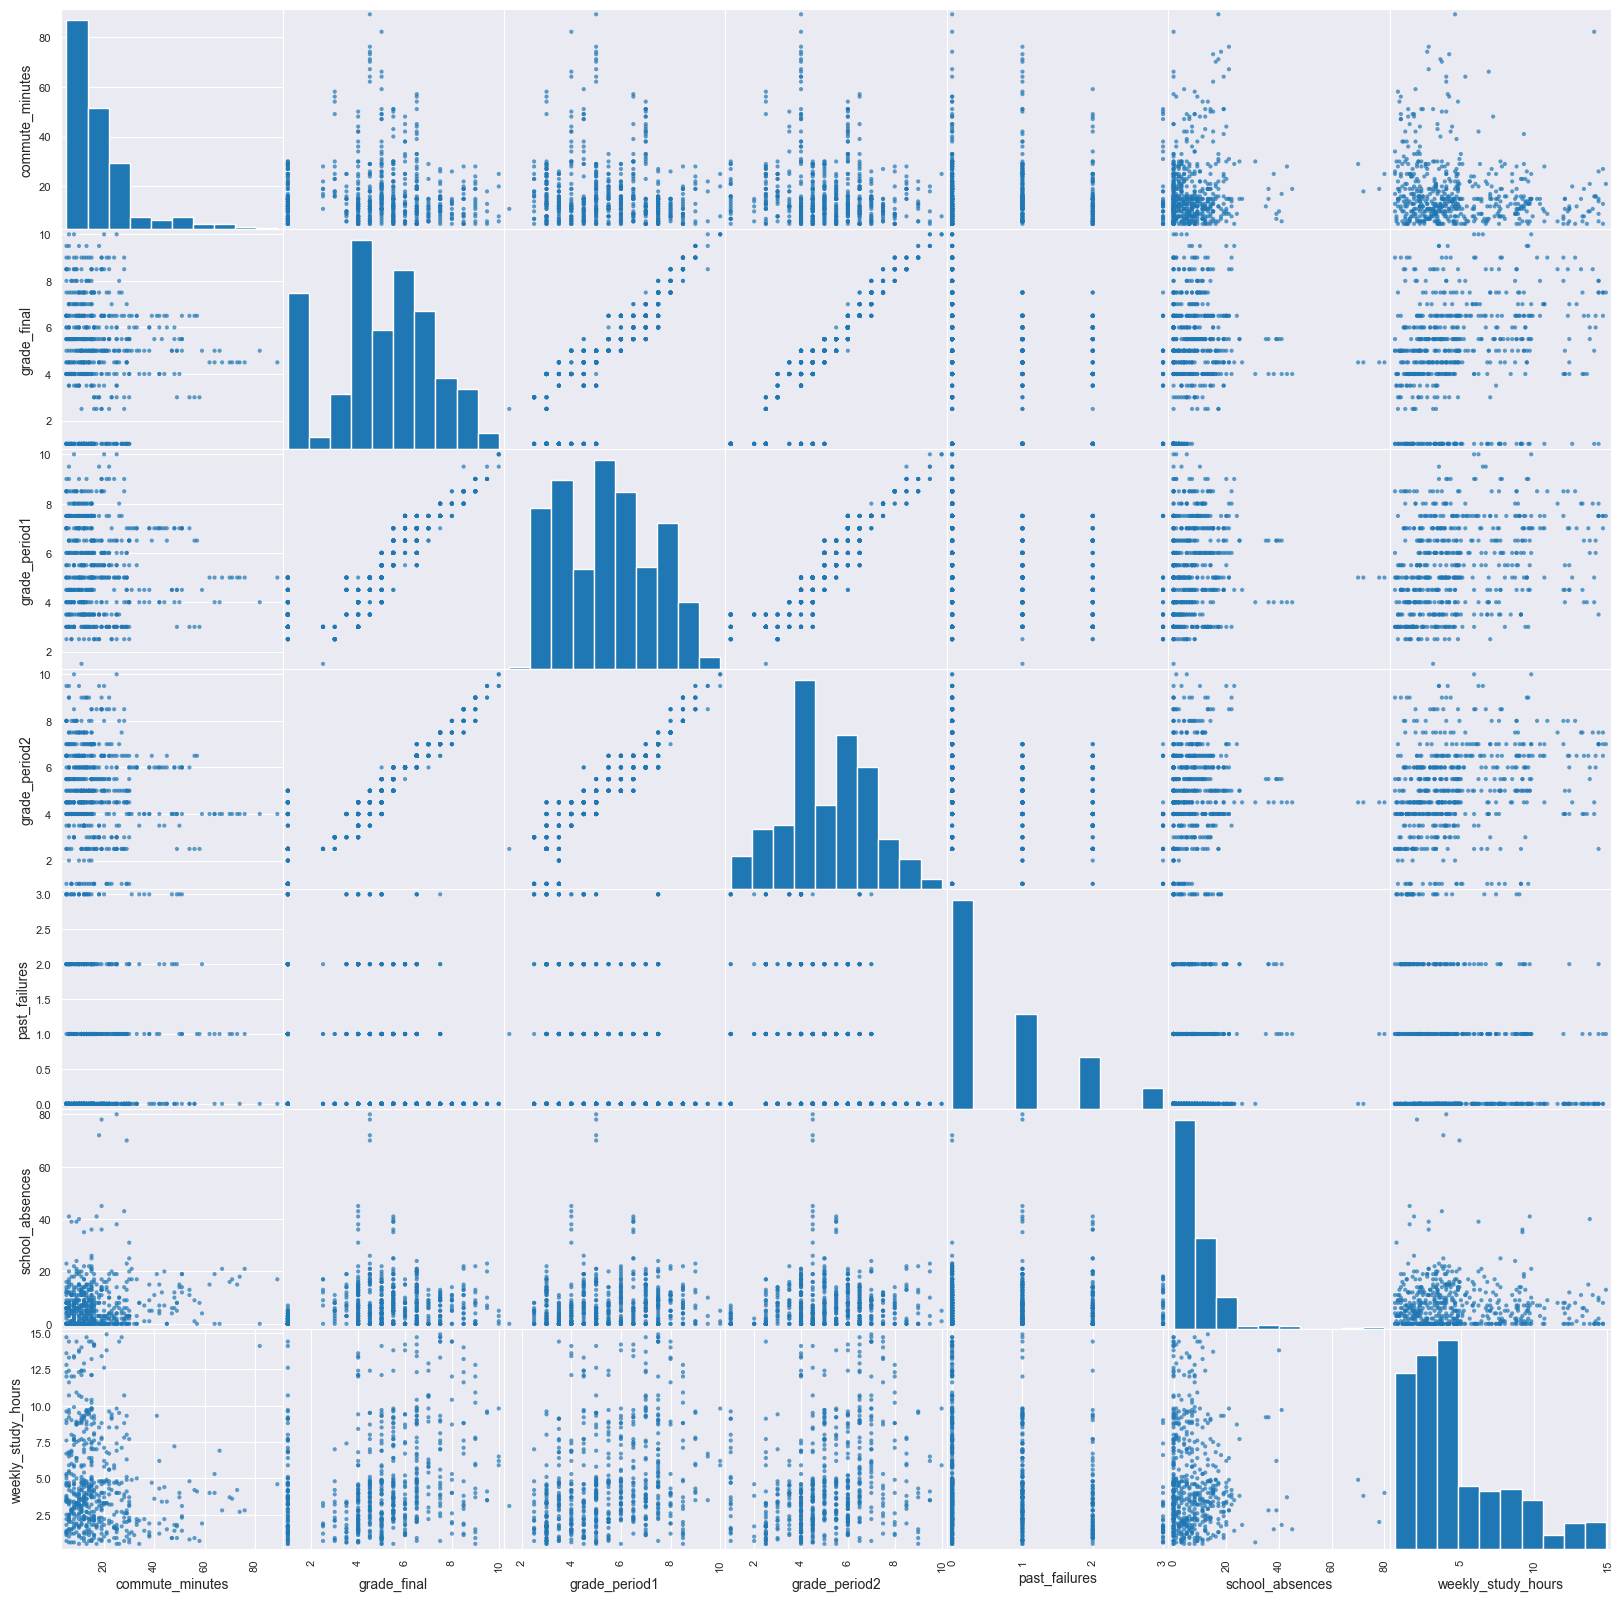

In [8]:
scatter_matrix(df1, figsize=(20, 20), diagonal="hist", alpha=0.7)
plt.show()

In [9]:
scaler = MinMaxScaler()
scaler.fit(df1) # dit hebben we later nodig
df1_scaled = scaler.fit_transform(df1)

In [10]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 10)
    covariance_type = trial.suggest_categorical("covariance_type", ["full", "diag", "tied", "spherical"])
    reg_covar = trial.suggest_float("reg_covar", 1e-6, 1e-2, log=True)

    gmm_model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)
    gmm_model.fit(df1)
    return gmm_model.bic(df1)

# maak Optuna-study met deze procedure aan
study = optuna.create_study(direction="minimize")

# voer Optuna grid search uit
optuna.logging.disable_default_handler() # optioneel: voorkom output per study
study.optimize(objective, n_trials=1000)

[I 2025-09-29 12:14:15,204] A new study created in memory with name: no-name-acc1ac3d-7356-4963-a806-08f76574a140


In [11]:
# bekijk optimalisatieproces
optuna.visualization.plot_optimization_history(study)

In [12]:
# bekijk slice plots
optuna.visualization.plot_slice(study)

In [13]:
best_params = study.best_params

In [14]:
best_params

{'n_components': 8,
 'covariance_type': 'full',
 'reg_covar': 1.1715230250361532e-06}

In [15]:
def bootstrap_gmm_stability(X, scaler=None, n_bootstraps=100, gmm_params=None):
    n_components = gmm_params.get("n_components", 9)
    covariance_type = gmm_params.get("covariance_type", "full")
    reg_covar = gmm_params.get("reg_covar", 1e-6)

    all_weights = []

    for i in range(n_bootstraps):
        X_resampled = resample(X, replace=True, random_state=i)

        if scaler is not None:
            X_resampled = scaler().fit_transform(X_resampled)

        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, reg_covar=reg_covar)

        gmm.fit(X_resampled)
        all_weights.append(gmm.weights_)

    return np.array(all_weights)

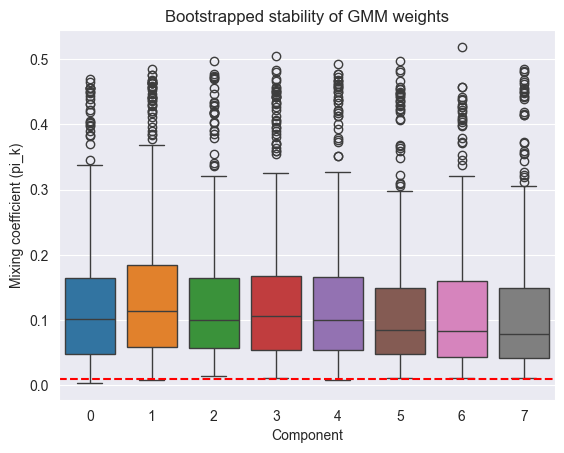

In [16]:
weights_matrix = bootstrap_gmm_stability(df1_scaled, scaler=MinMaxScaler, n_bootstraps=500, gmm_params=best_params)

# visualiseer gewichten
sns.boxplot(data=weights_matrix)
plt.xlabel("Component")
plt.ylabel("Mixing coefficient (pi_k)")
plt.title("Bootstrapped stability of GMM weights")
plt.axhline(0.01, linestyle = 'dashed', color = 'red')
plt.show()

In [17]:
best_gmm = GaussianMixture(n_components=9, covariance_type=best_params['covariance_type'], reg_covar=best_params['reg_covar'])
best_gmm.fit(df1_scaled)

GaussianMixture(n_components=9, reg_covar=1.1715230250361532e-06)

In [18]:
df1.columns

Index(['commute_minutes', 'grade_final', 'grade_period1', 'grade_period2',
       'past_failures', 'school_absences', 'weekly_study_hours'],
      dtype='object')

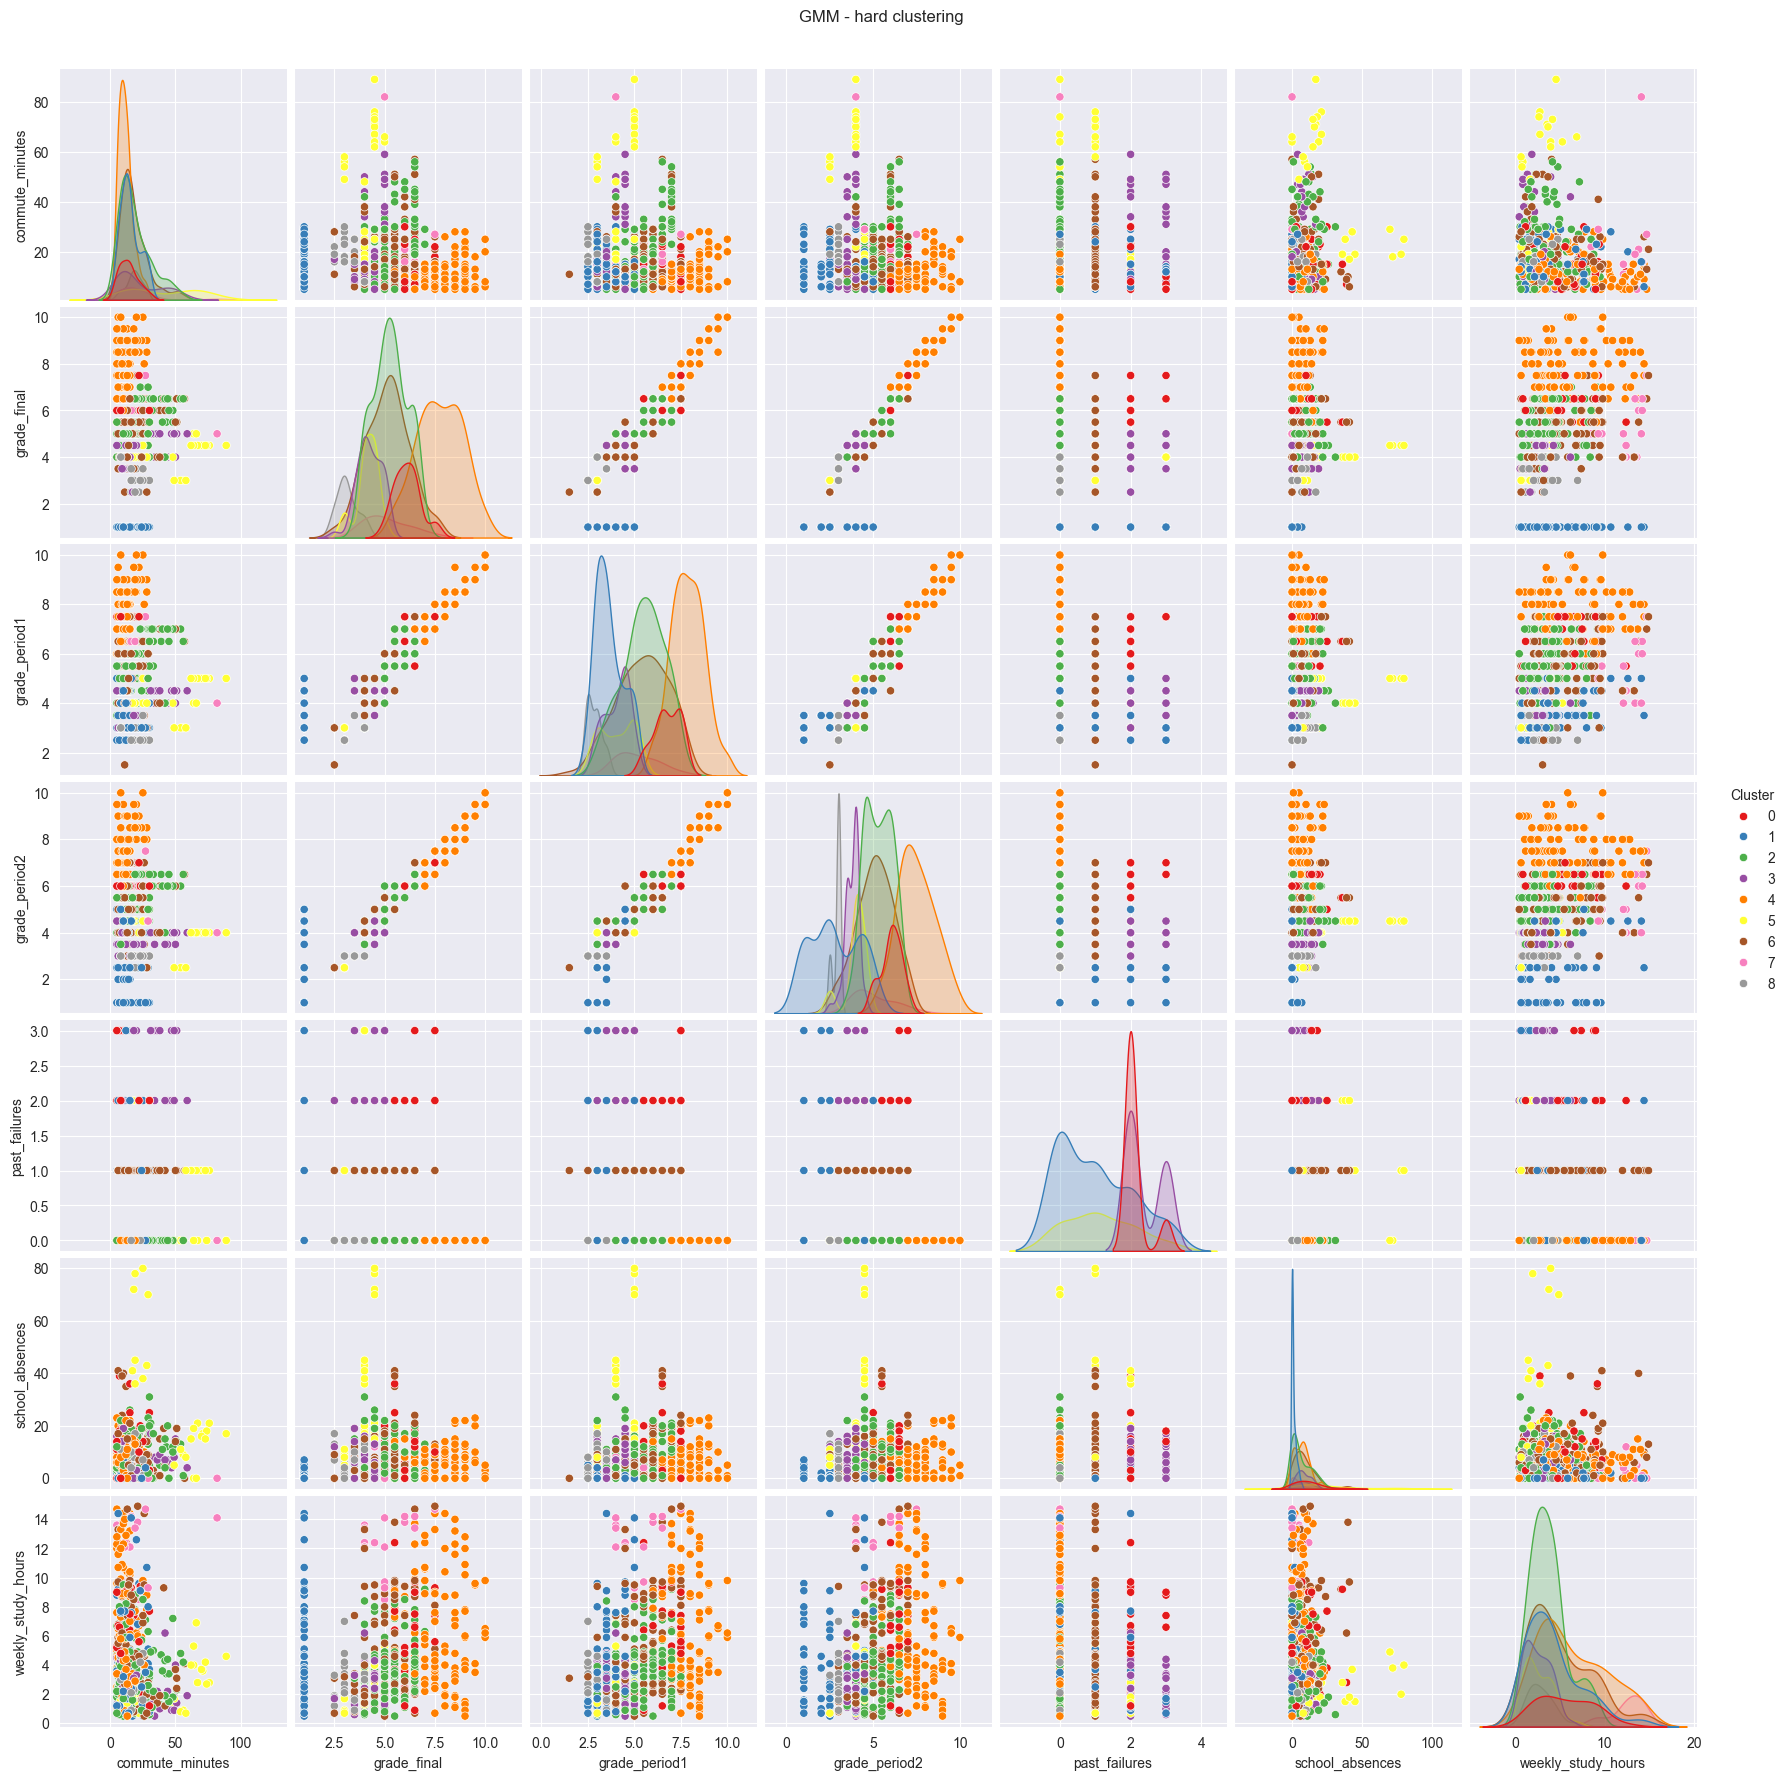

In [19]:
# pas hard clustering toe op basis van GMM
labels = best_gmm.predict(df1_scaled)

# voeg clusterlabels toe aan de data
input_data = df1.copy()
input_data.loc[:,'Cluster'] = labels

# pairplot
sns.pairplot(
    data=input_data,
    vars=['commute_minutes', 'grade_final', 'grade_period1', 'grade_period2',
       'past_failures', 'school_absences', 'weekly_study_hours'],
    hue='Cluster',
    palette="Set1",
    diag_kind="kde",
)
plt.suptitle("GMM - hard clustering", y=1.02)
plt.show()

C:\Users\mitch\AppData\Local\Temp\ipykernel_27416\1267166595.py:55: RuntimeWarning:

invalid value encountered in divide

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1454: UserWarning:


c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1455: UserWarning:


C:\Users\mitch\AppData\Local\Temp\ipykernel_27416\1267166595.py:55: RuntimeWarning:

invalid value encountered in divide

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1454: UserWarning:


c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1455: UserWarning:


C:\Users\mitch\AppData\Local\Temp\ipykernel_27416\1267166595.py:55: RuntimeWarning:

invalid value encountered in divide

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\contour.py:1454: UserWarning:


c:\Users\mitch\AppData\Local\Programs\Python\Python310

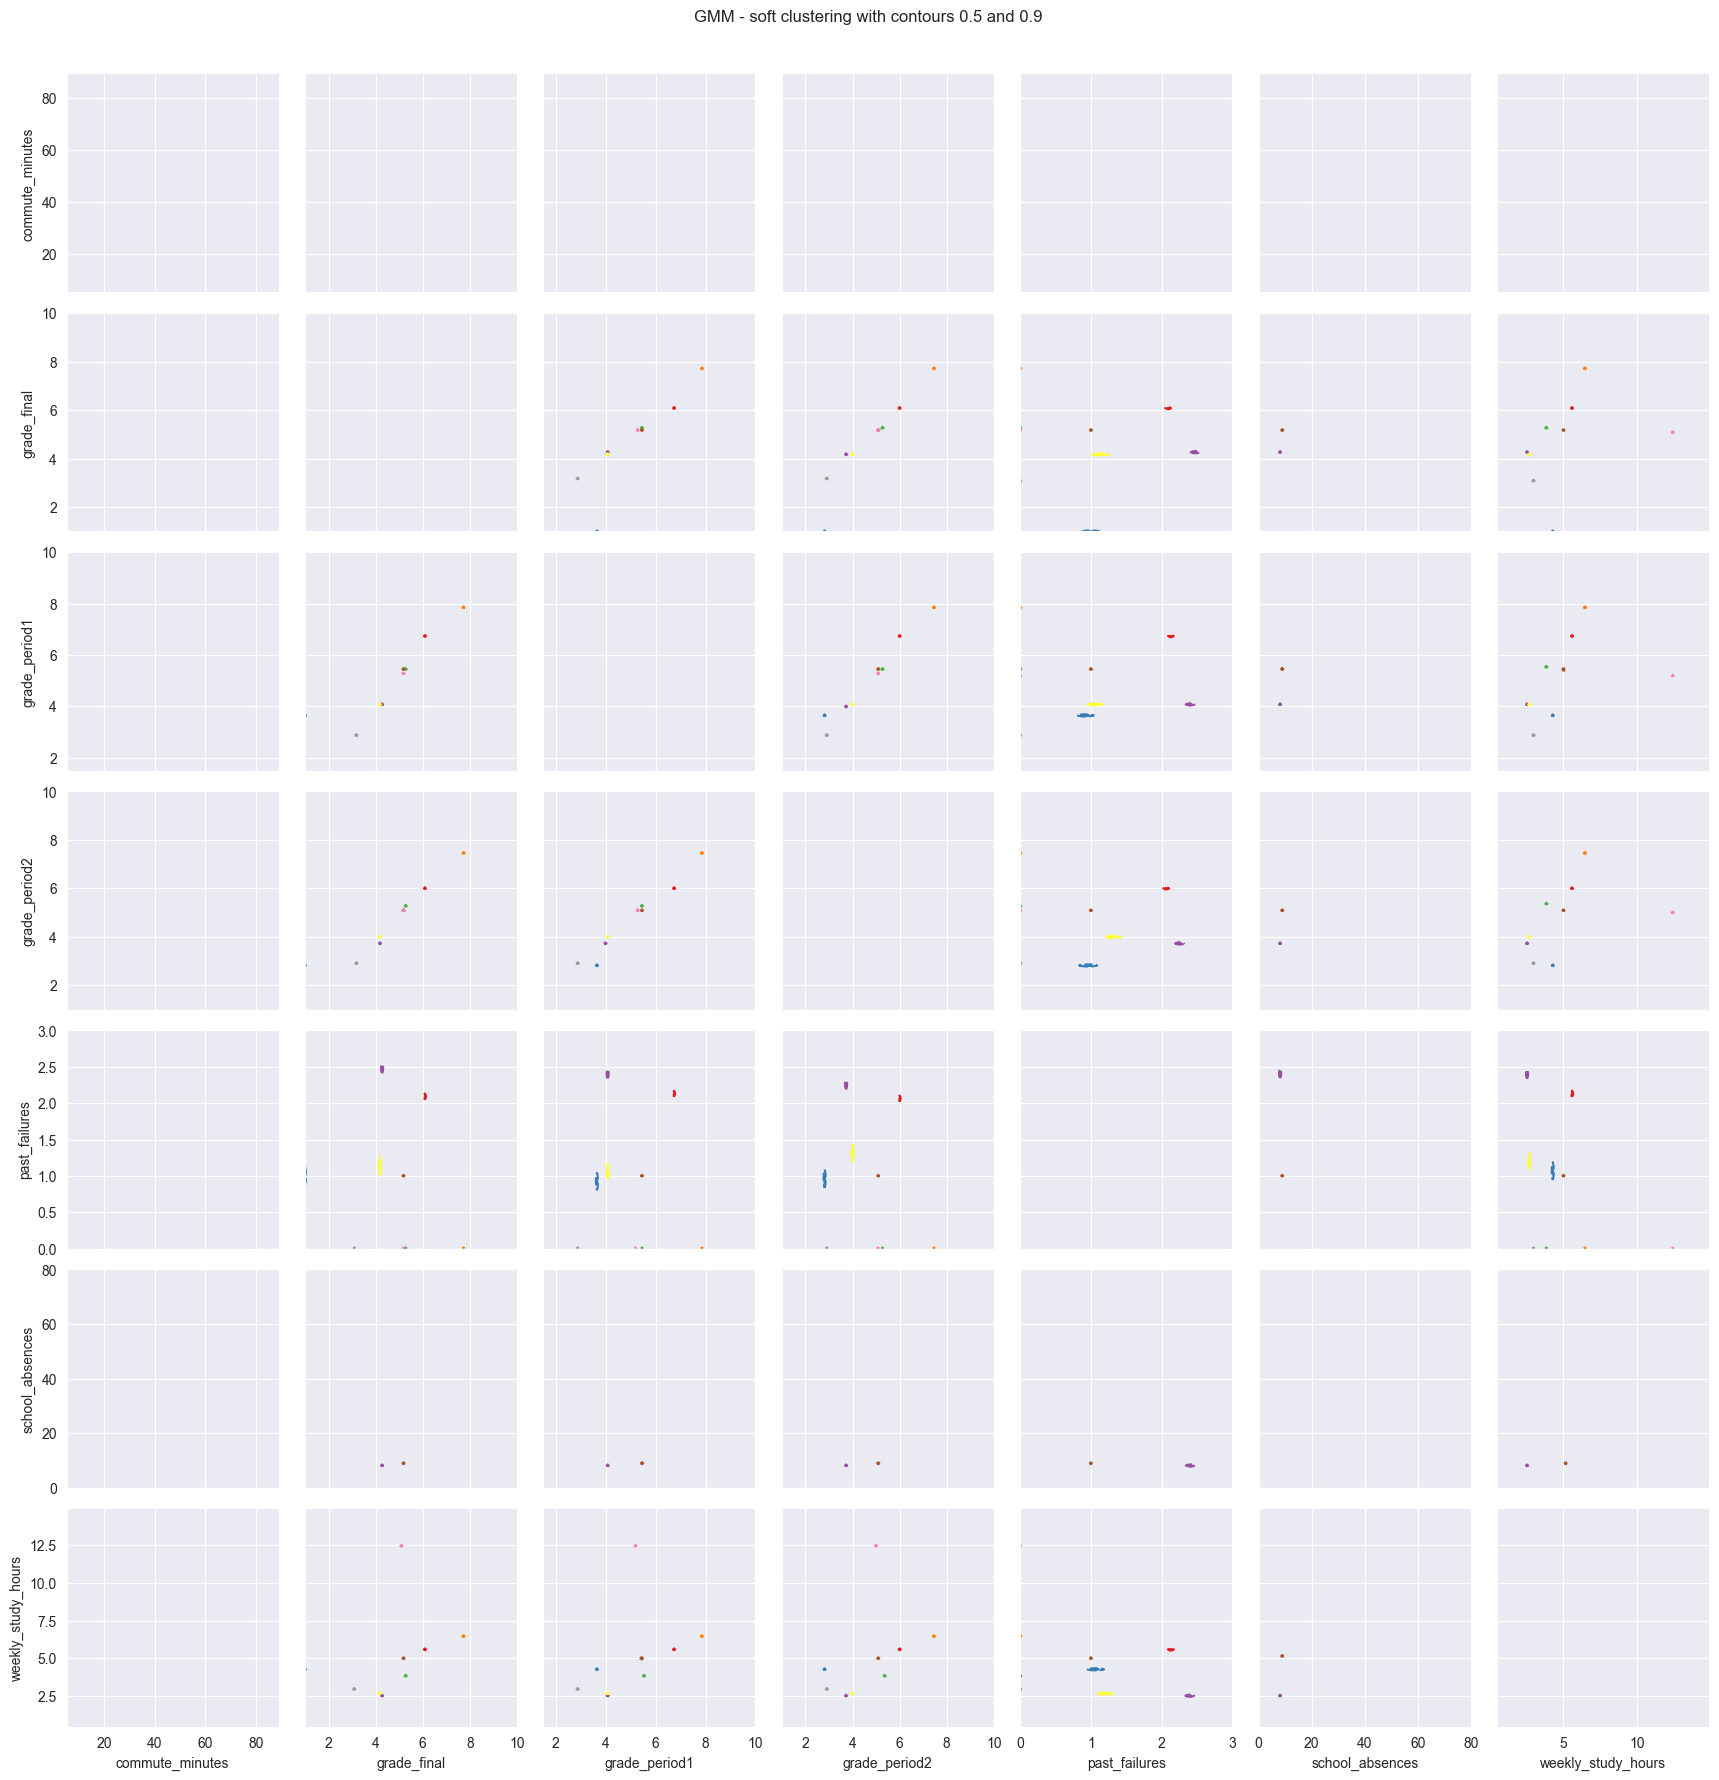

In [20]:
# bouw de pairplotmatrix voor soft clustering
features = ['commute_minutes', 'grade_final', 'grade_period1', 'grade_period2',
       'past_failures', 'school_absences', 'weekly_study_hours']
g = sns.PairGrid(df1, vars=features)

# transformeer de GMM-parameters terug naar de originele schaal
means_original = scaler.inverse_transform(best_gmm.means_)

scale = scaler.scale_
covariances_original = []
for diag_var in best_gmm.covariances_:
    if diag_var.ndim == 1:
        # diag_var bevat varianties per feature in geschaalde ruimte
        original_variances = diag_var * (scale ** 2)
        cov_matrix = np.diag(original_variances)
    else:
        # voor 'full' covariance_type
        cov_matrix = diag_var * scale[:, None] * scale[None, :]
    covariances_original.append(cov_matrix)
#scale = scaler.data_range_  
#covariances_original = [
#    np.diag(diag_var * scale**2) if diag_var.ndim == 1 else diag_var * scale**2
#    for diag_var in best_gmm.covariances_
#]

# functie voor plotten contours (soft clustering)
def plot_gmm_contours(x, y, levels=[0.5, 0.9], **kwargs):
    ax = plt.gca()
    palette = sns.color_palette("Set1", best_gmm.n_components)

    # plot niets op de diagonaal (voegt niets toe)
    if x.name == y.name:
        return

    xi = features.index(x.name)
    yi = features.index(y.name)

    for i in range(best_gmm.n_components):
        mean = means_original[i][[xi, yi]]
        cov = covariances_original[i][np.ix_([xi, yi], [xi, yi])]
        eigvals = np.linalg.eigvalsh(cov)

        # maak het grid
        x_range = input_data[x.name]
        y_range = input_data[y.name]
        xx, yy = np.meshgrid(
            np.linspace(x_range.min(), x_range.max(), 100),
            np.linspace(y_range.min(), y_range.max(), 100)
        )
        pos = np.dstack((xx, yy))
        rv = multivariate_normal(mean, cov)
        z = rv.pdf(pos)

        # normaliseer
        z /= z.max()

        # plot gewenste contouren
        for level in levels:
            linestyle = 'dashed' if level < 0.7 else 'solid'
            ax.contour(xx, yy, z, levels=[level], colors=[palette[i]], linestyles=linestyle)

# maak de plot
g.map(plot_gmm_contours, levels = [0.5, 0.9])
g.map_diag(lambda *args, **kwargs: None)
plt.suptitle("GMM - soft clustering with contours 0.5 and 0.9", y=1.02)

# geef de plot weer
plt.show()

Les 8

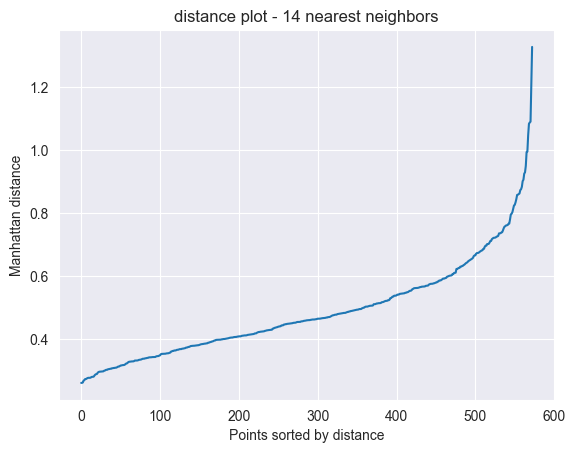

In [21]:
# verzamel afstanden
k = 2 * df1_scaled.shape[1]
neighbors = NearestNeighbors(n_neighbors=k, metric='manhattan')
neighbors_fit = neighbors.fit(df1_scaled)
distances, indices = neighbors_fit.kneighbors(df1_scaled)

# maak distance plot
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.title(f"distance plot - {k} nearest neighbors")
plt.xlabel("Points sorted by distance")
plt.ylabel("Manhattan distance")
plt.grid(True)
plt.show()

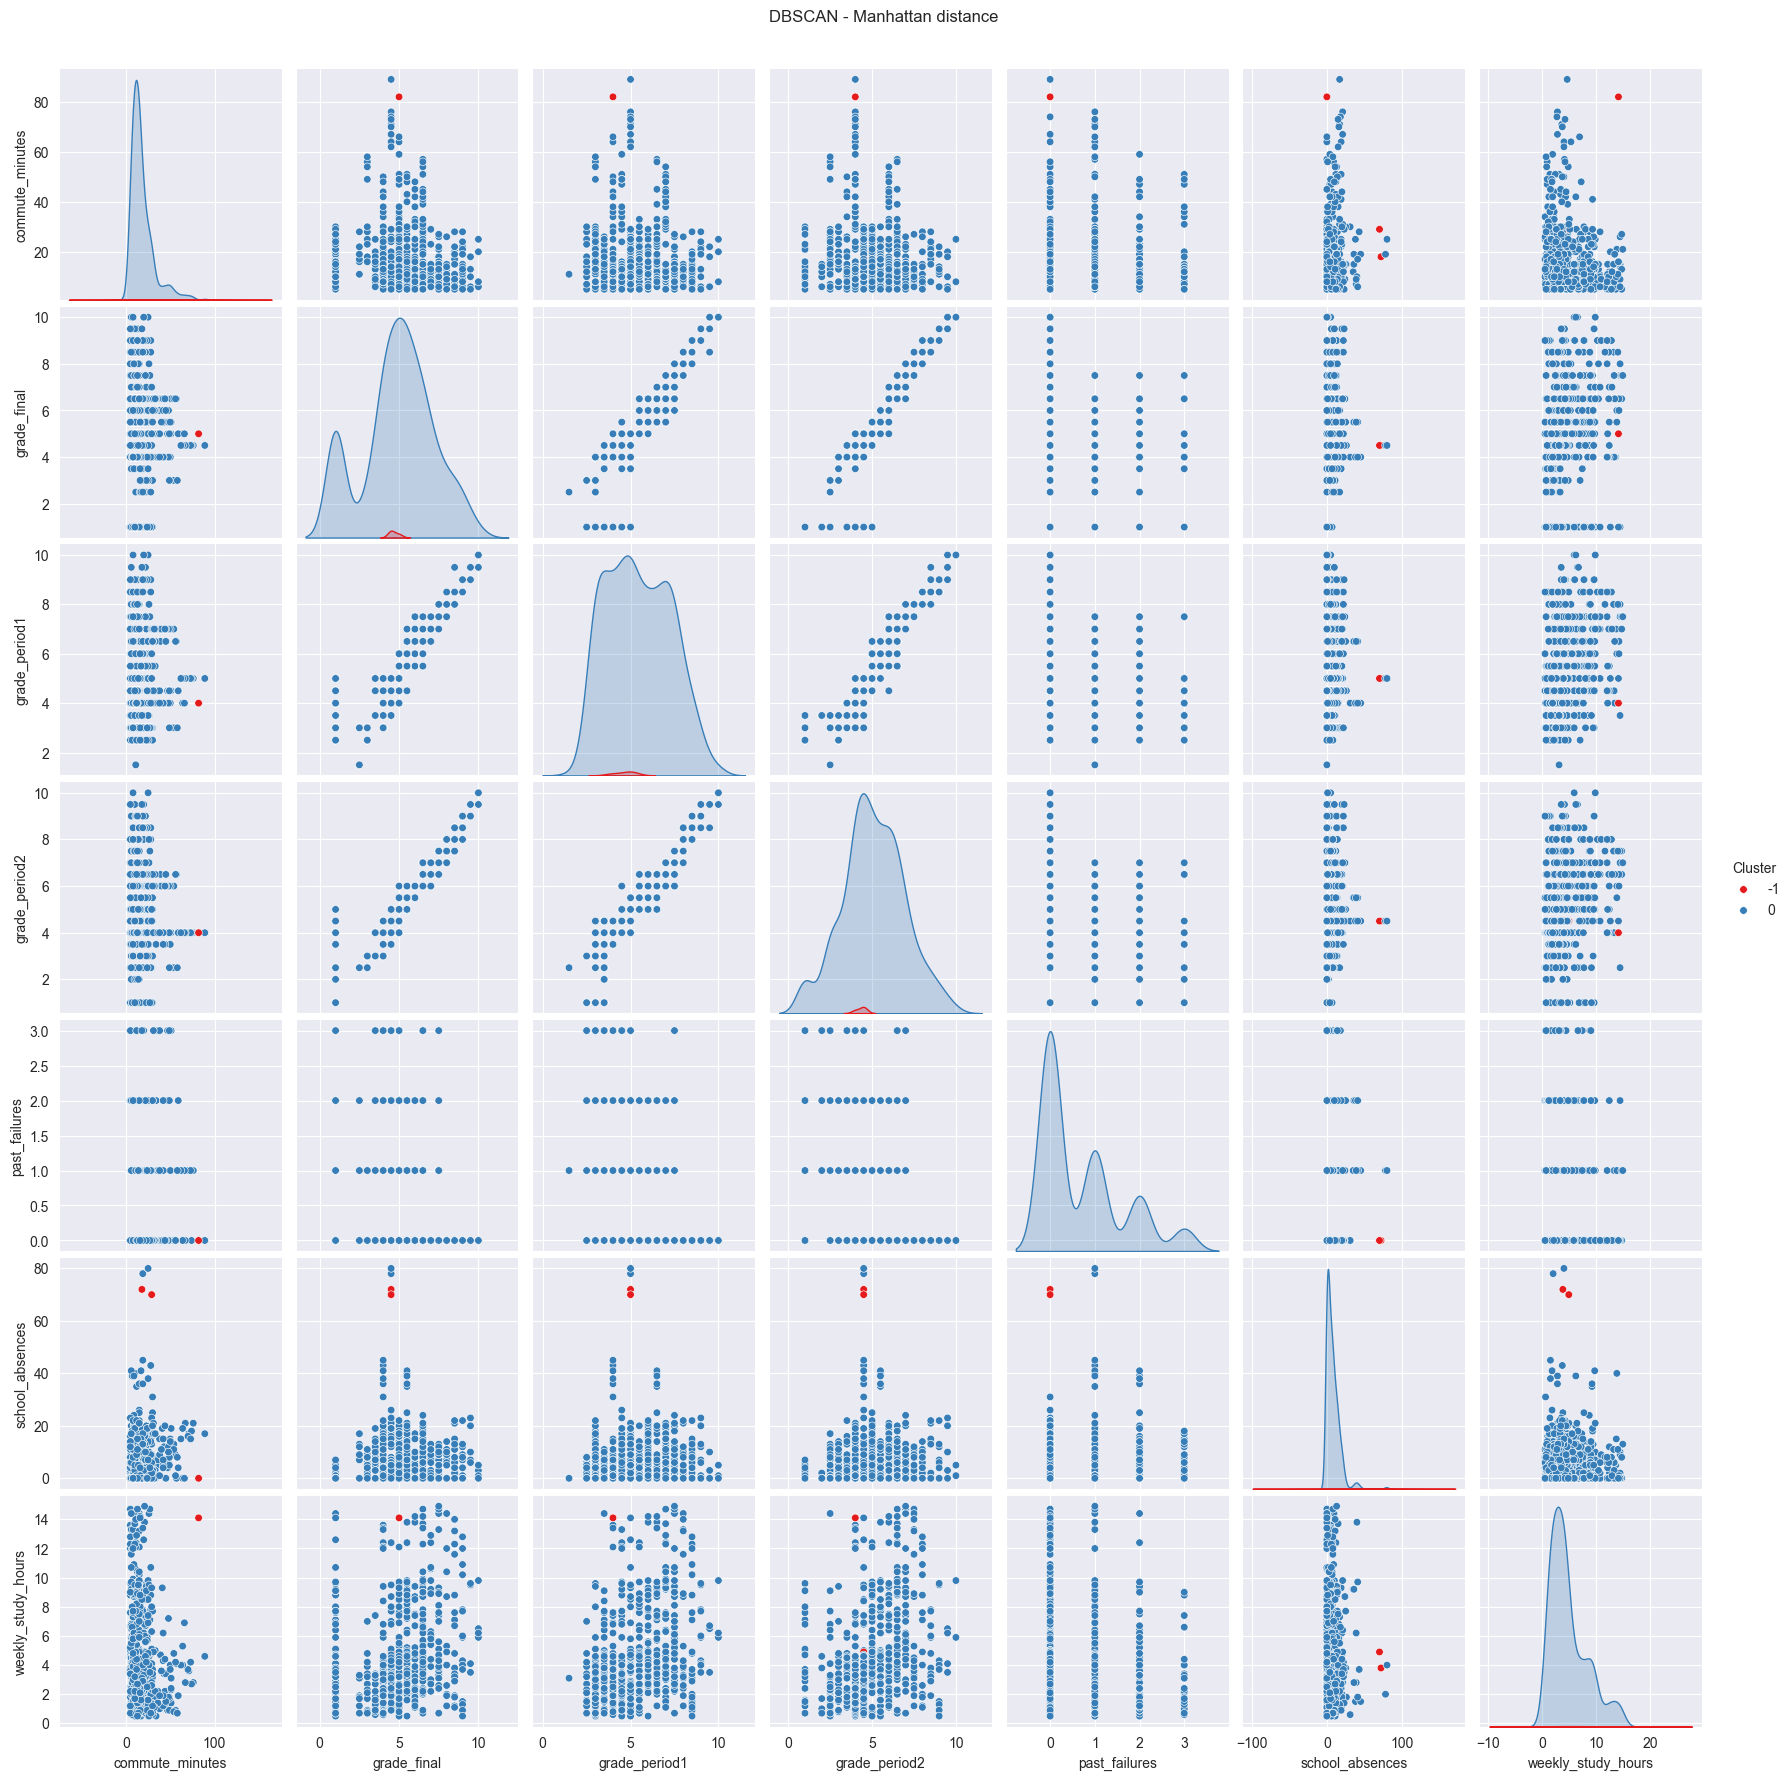

In [26]:
# voer DBSCAN uit
dbscan = DBSCAN(eps=0.8, min_samples=k, metric='manhattan')
dbscan_fit = dbscan.fit(df1_scaled)

# haal de clusterlabels en classificaties van punten op
labels = dbscan_fit.labels_

# plot clustering in pairplot
input_data = input_data.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("DBSCAN - Manhattan distance", y=1.02)
plt.show()

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\mitch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



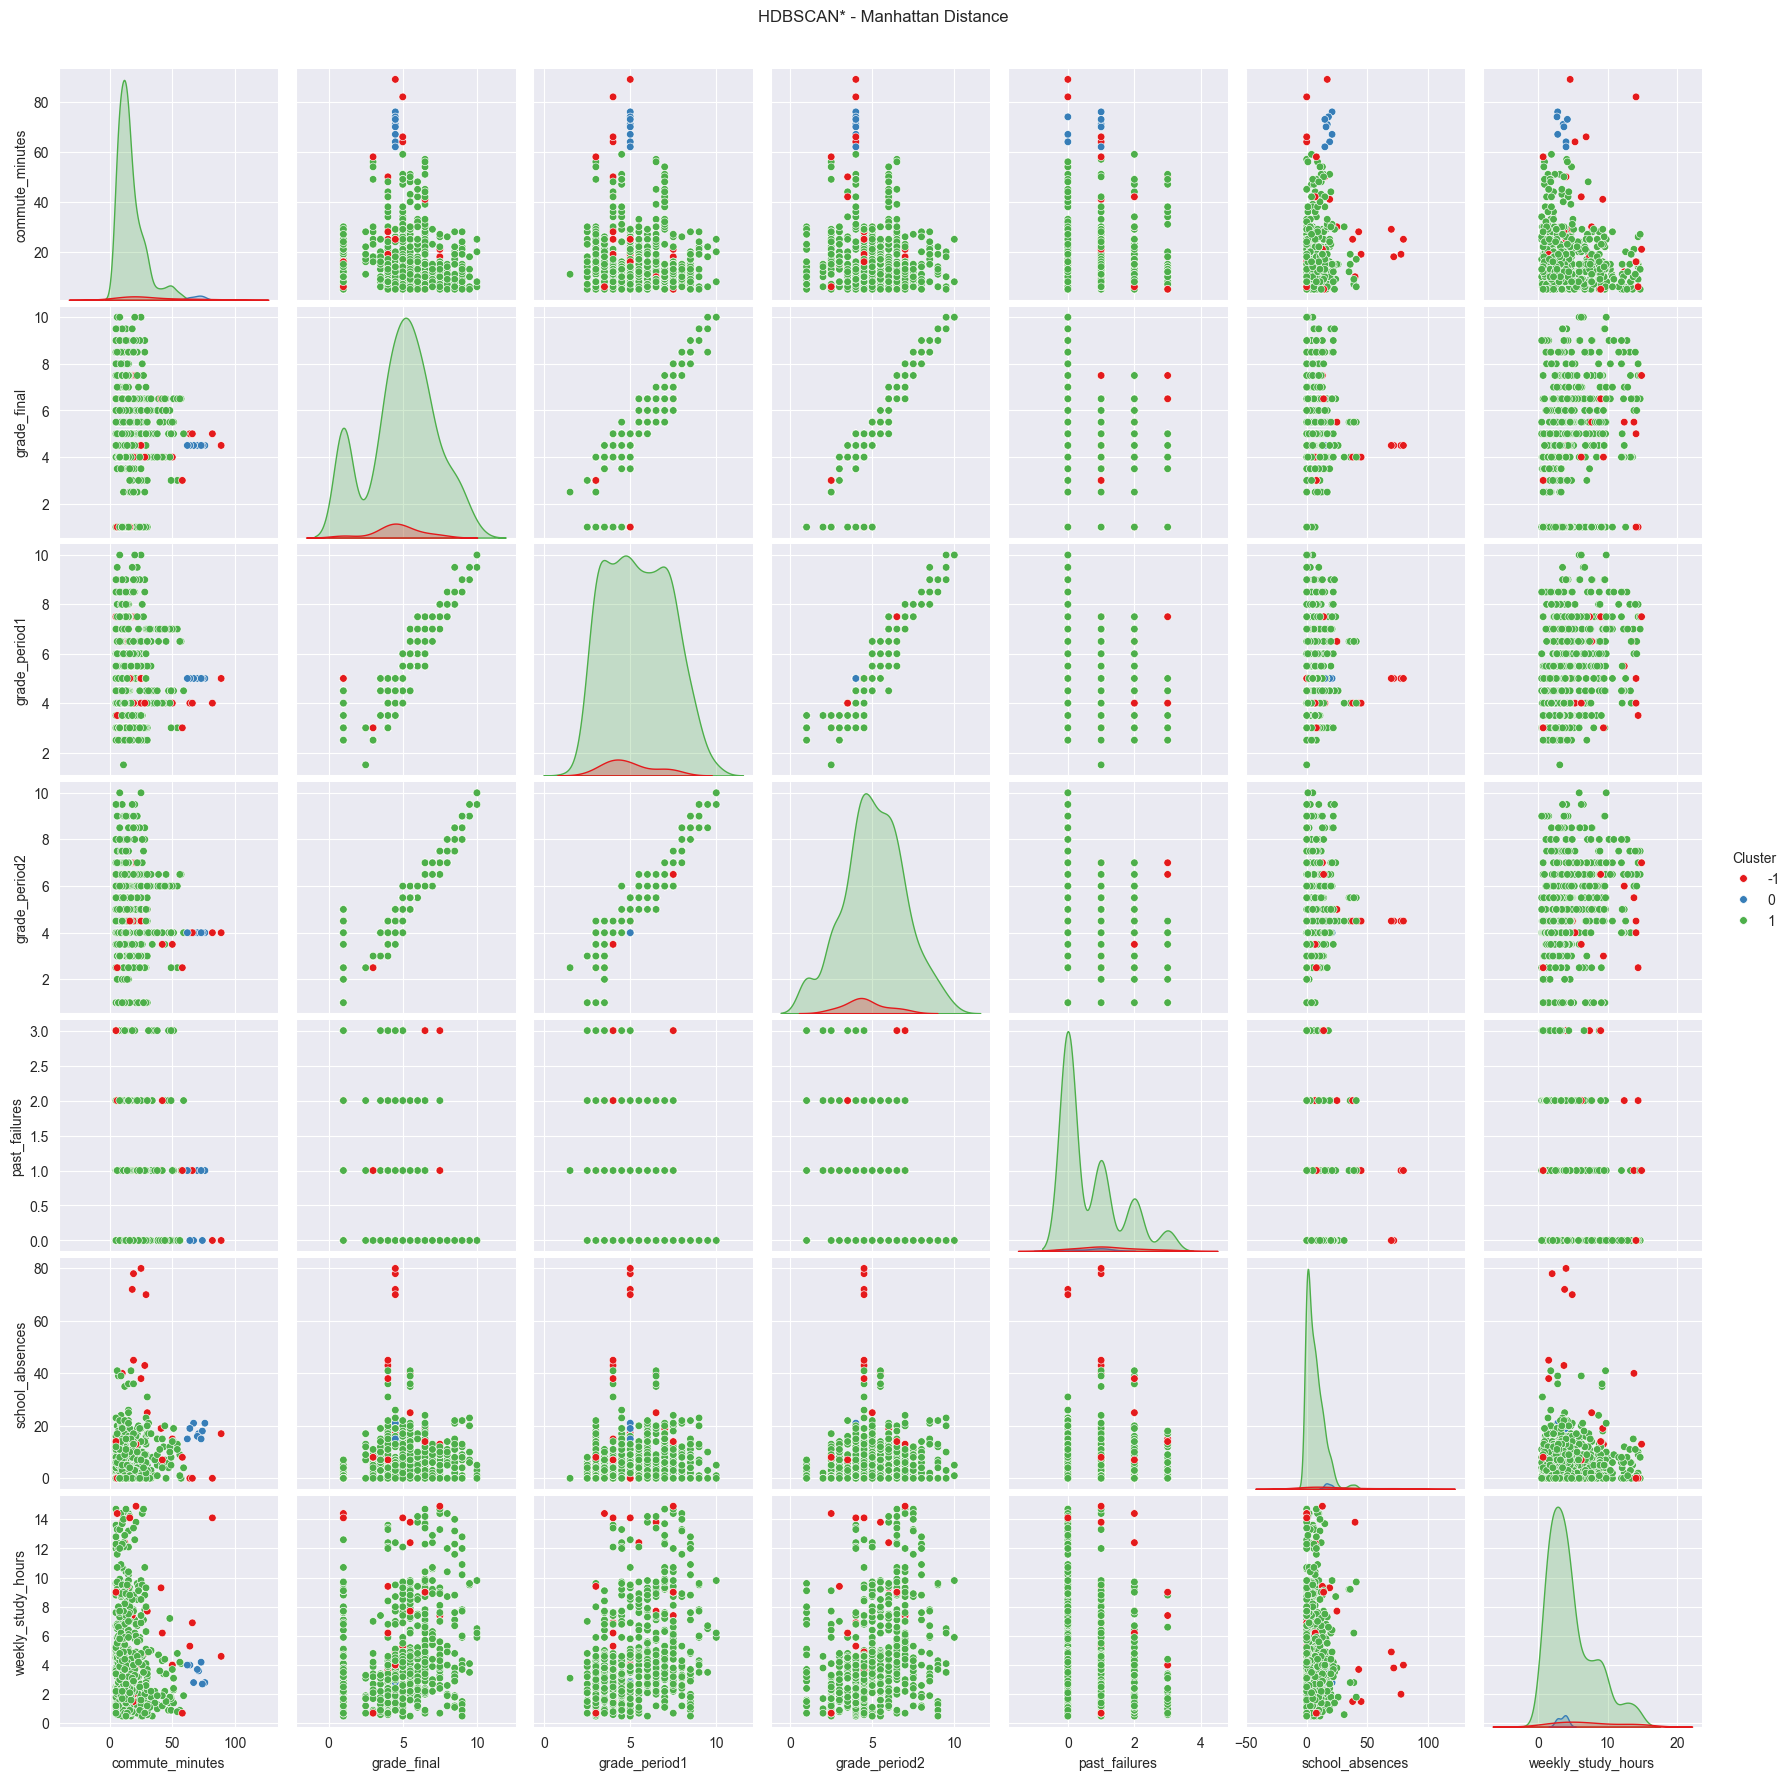

In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 2*3, metric = 'manhattan')
labels = clusterer.fit_predict(df1_scaled)

# plot clustering in pairplot
input_data = input_data.copy()
input_data.loc[:,'Cluster'] = labels

sns.pairplot(input_data, hue="Cluster", palette="Set1", diag_kind="kde", plot_kws={"s": 30})
plt.suptitle("HDBSCAN* - Manhattan Distance", y=1.02)
plt.show()